<h1 style="font-size: 36px;"> Introducción al problema</h1>

El objetivo de esta práctica es ayudar al banco a tomar mejores decisiones a la hora de aprobar préstamos. La idea es analizar datos históricos de solicitudes para encontrar patrones que permitan distinguir entre clientes que cumplen con sus pagos y aquellos que no. Así, el banco podrá evaluar mejor las solicitudes futuras, evitando rechazar a buenos clientes y reduciendo los riesgos de impagos.

**Problema a resolver:**  Lo que buscamos es identificar las características o señales que indiquen un mayor riesgo de que un cliente no pague su préstamo. Esto ayudará a tomar decisiones más inteligentes, minimizando las pérdidas por impagos y evitando rechazar a personas que sí son buenas pagadoras. Para lograrlo, voy a construir un modelo de aprendizaje supervisado que prediga de forma más precisa el riesgo de incumplimiento.

**Variables disponibles en producción:**
El modelo solo utilizará las variables disponibles en el momento en que se solicita el préstamo. Esto incluye la información proporcionada por el cliente, como datos financieros, demográficos y laborales, junto con cualquier otra información recopilada antes de la aprobación del préstamo. No se tendrán en cuenta variables relacionadas con lo que pase después de otorgarlo.

**Evaluación del modelo:** 
La evaluación se centrará en medir qué tan bien el modelo identifica a clientes confiables y a los que representan un mayor riesgo. Para esto, utilizaremos métricas como precisión, recall y la curva ROC-AUC. Además, consideraremos el impacto en el negocio, enfocándonos en reducir las pérdidas por impagos y mejorar la aprobación de clientes solventes.

**Conclusiones esperadas del EDA:**  Con el análisis exploratorio de datos (EDA), queremos responder si hay un perfil claro de cliente que sea más propenso a no pagar su préstamo. Esto implica buscar patrones y características en los datos que estén asociadas con un mayor riesgo de incumplimiento.

Por último, es clave que todo el análisis y el desarrollo del modelo se realice con un código claro y eficiente. Esto no solo facilita el entendimiento del trabajo, sino que también asegura que sea fácil de mantener y mejorar en el futuro.

In [32]:
# Comprobamos el environment
# ==============================================================================
import sys

print(sys.version)
print(sys.path)
print("---")
print(sys.executable)

3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 08:28:27) [Clang 14.0.6 ]
['/opt/anaconda3/envs/practica1b/lib/python312.zip', '/opt/anaconda3/envs/practica1b/lib/python3.12', '/opt/anaconda3/envs/practica1b/lib/python3.12/lib-dynload', '', '/Users/oscar/.local/lib/python3.12/site-packages', '/opt/anaconda3/envs/practica1b/lib/python3.12/site-packages', '/opt/anaconda3/envs/practica1b/lib/python3.12/site-packages/setuptools/_vendor']
---
/opt/anaconda3/envs/practica1b/bin/python


<h1 style="font-size: 36px;">Análisis inicial</h1>

El objetivo de este notebook es realizar un análisis exploratorio inicial para obtener una mejor comprensión del problema que estamos tratando de resolver.

# Librerías:

Las librerías utilizadas en este notebook son:

In [33]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
from plotnine import *

In [34]:
# Configuración pandas
# ==============================================================================
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Funciones: 

Importamos las funciones necesarias para este notebook.

In [36]:
import sys
sys.path.append("../scr/")
import funciones 
sys.path.remove('../scr/')

In [37]:
# Recarga el módulo
# ==============================================================================
import importlib
sys.path.append("../scr/")
importlib.reload(funciones)
sys.path.remove('../scr/')

# Datos:

El set de datos contiene información sobre contiene información sobre el comportamiento de pago de más de 300 000 préstamos.

In [38]:
path_folder = "../data/raw/application_data.csv"
pd_loan = pd.read_csv(path_folder)

# Diccionario de datos:


Incluimos el diccionario de datos para facilitar la comprensión de las variables.

In [64]:
dictionary_folder = "../data/columns_description.xlsx"
pd_dictionary = pd.read_excel(dictionary_folder)

# Mostrar las primeras filas del diccionario de datos
# ==============================================================================
pd_dictionary.head()

,Unnamed: 0,Table,Row,Description,Special
0,1,application_data,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_data,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_data,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_data,CODE_GENDER,Gender of the client,NaN
4,7,application_data,FLAG_OWN_CAR,Flag if the client owns a car,NaN


# Exploración general de la tabla:

Antes de comenzar a entrenar un modelo predictivo, es fundamental llevar a cabo una exploración descriptiva detallada. Este análisis inicial nos permite entender mejor qué información contiene cada variable, identificar posibles errores y tomar decisiones informadas sobre el tratamiento de los datos.

En este primer análisis, examinaremos las variables y estudiaremos la distribución y características de los datos. Esto incluye aspectos como los tipos de datos, la presencia de valores nulos y las diferentes columnas disponibles en el conjunto.

Además, este proceso preliminar puede proporcionar pistas valiosas sobre qué variables son las más adecuadas como predictores en un modelo, algo que exploraremos con mayor detalle en los siguientes apartados.

In [39]:
pd_loan.head(4)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

## Tipos de cada columna:

In [40]:
# Tipo de cada columna
# ==============================================================================
# En pandas, el tipo "object" hace referencia a strings
pd_loan.info(verbose=True)

# pd_loan.dtypes 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    TARGET                        int64  
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  int64  
 7    AMT_INCOME_TOTAL              float64
 8    AMT_CREDIT                    float64
 9    AMT_ANNUITY                   float64
 10   AMT_GOODS_PRICE               float64
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float64
 17   DAYS_BIRTH                    int64  
 18   DA

Podemos ver que los datos se dividen en tres tipos: enteros, números decimales y objetos. Más adelante lo analizaremos más a fondo, pero los datos tipo float suelen ser variables continuas, mientras que los de tipo object guardan texto y variables categóricas. En cuanto a los enteros, pueden representar tanto variables categóricas, como valores booleanos, como variables continuas, dependiendo del contexto.

In [41]:
# Cantidad de cada tipo datos en la columna
# ==============================================================================
pd_loan.dtypes.sort_values().to_frame('feature_type').groupby(by = 'feature_type').size().to_frame('count').reset_index()

,feature_type,count
0,int64,41
1,float64,65
2,object,16


## Número de observaciones y datos faltantes:

Además de revisar el tipo de variables, es importante saber cuántas observaciones tenemos y si todo está completo. Los datos faltantes son algo a tener en cuenta porque muchos modelos no los procesan bien o se ven bastante afectados. Más adelante vamos a trabajar en rellenar esos valores, pero antes necesitamos identificarlos para poder decidir cómo manejarlos de la mejor manera.

In [42]:
# Dimensiones del dataset
# ==============================================================================
pd_loan.shape

(307511, 122)

In [43]:
# Número de datos ausentes por variable
# ==============================================================================
pd_loan.isna().sum().sort_values()

SK_ID_CURR                           0
HOUR_APPR_PROCESS_START              0
REG_REGION_NOT_WORK_REGION           0
LIVE_REGION_NOT_WORK_REGION          0
REG_CITY_NOT_LIVE_CITY               0
REG_CITY_NOT_WORK_CITY               0
LIVE_CITY_NOT_WORK_CITY              0
ORGANIZATION_TYPE                    0
FLAG_DOCUMENT_21                     0
FLAG_DOCUMENT_20                     0
FLAG_DOCUMENT_19                     0
FLAG_DOCUMENT_18                     0
FLAG_DOCUMENT_17                     0
FLAG_DOCUMENT_16                     0
FLAG_DOCUMENT_15                     0
FLAG_DOCUMENT_14                     0
FLAG_DOCUMENT_13                     0
FLAG_DOCUMENT_12                     0
FLAG_DOCUMENT_11                     0
FLAG_DOCUMENT_10                     0
FLAG_DOCUMENT_9                      0
FLAG_DOCUMENT_8                      0
FLAG_DOCUMENT_7                      0
FLAG_DOCUMENT_6                      0
FLAG_DOCUMENT_5                      0
FLAG_DOCUMENT_4          

Muchas de las variables contienen valores ausentes. En las siguientes secciones, abordaremos este problema utilizando diversas estrategias para imputar los valores faltantes. 

In [44]:
# Comprobar si hay filas duplicadas
# ==============================================================================
pd_loan.drop_duplicates().shape

(307511, 122)

En principio, no hay duplicados exactos en nuestra muestra de datos. 

## Exploración de la variable objetivo:

La variable objetivo, `TARGET`, indica si un cliente ha tenido problemas para pagar el préstamo. Un valor de 1 significa que hubo un retraso importante en el pago, mientras que un 0 indica que no hubo problemas. Esta variable es clave para construir el modelo.

In [45]:
# Contar la frecuencia de los valores de la variable objetivo
# ==============================================================================
pd_plot_target = pd_loan['TARGET']\
        .value_counts(normalize=True)\
        .mul(100).rename('percent').reset_index()

pd_plot_target_conteo = pd_loan['TARGET'].value_counts().reset_index()

pd_plot_target_pc = pd.merge(pd_plot_target, pd_plot_target_conteo, on=['TARGET'], how='inner')
pd_plot_target_pc

,TARGET,percent,count
0,0,91.927118,282686
1,1,8.072882,24825


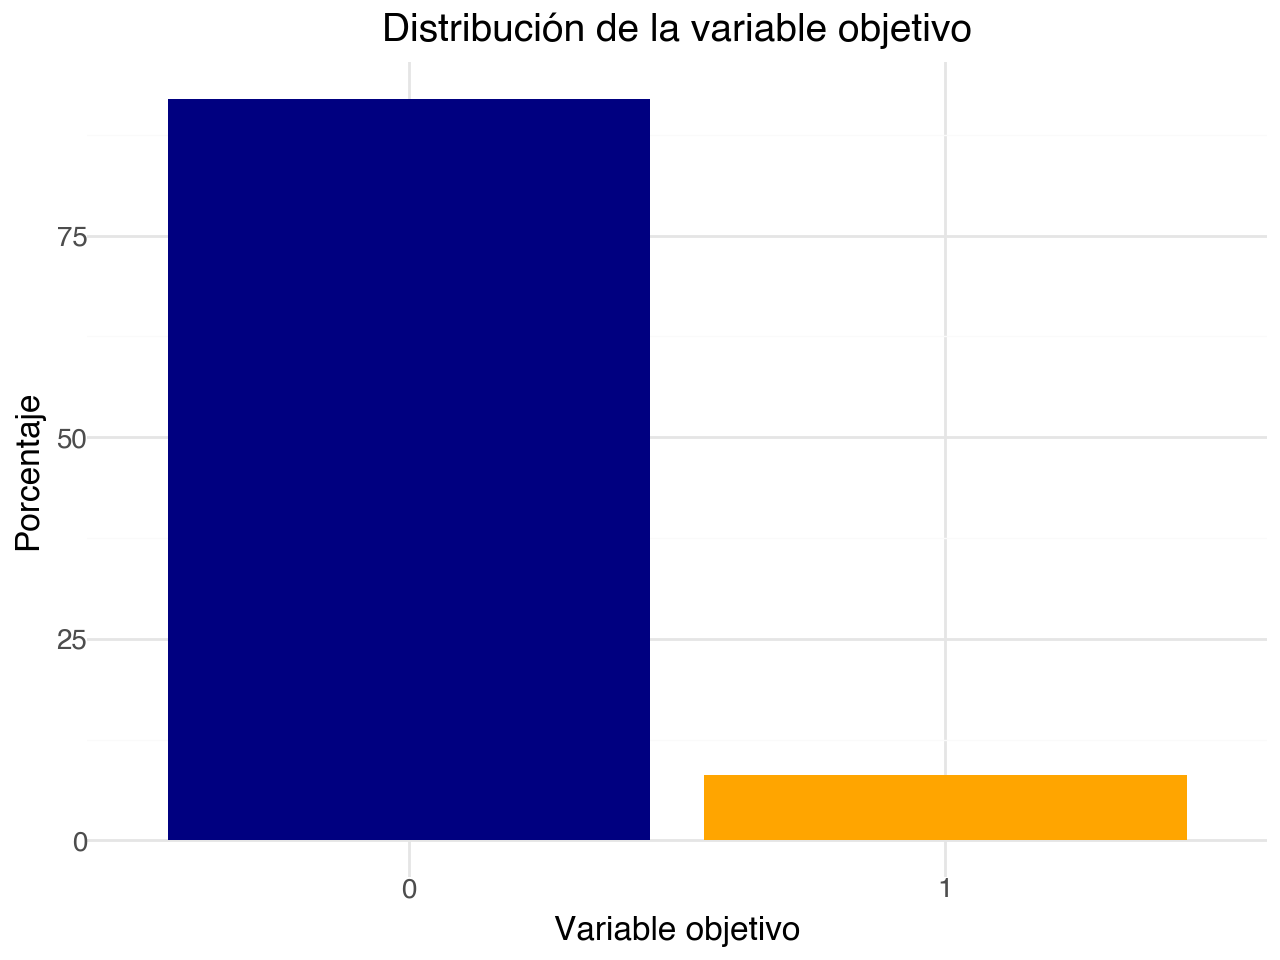

In [46]:
# Visualizar el conteo de los valores de la variable objetivo
# ==============================================================================
pd_plot_target_pc['TARGET'] = pd_plot_target_pc['TARGET'].astype(str)

(ggplot(pd_plot_target_pc, aes(x='TARGET', y='percent', fill='TARGET')) 
    + geom_bar(stat='identity', show_legend=False)  
    + labs(
        x='Variable objetivo', 
        y='Porcentaje', 
        title='Distribución de la variable objetivo'
    ) 
    + scale_fill_manual(values=['navy', 'orange'])  
    + theme_minimal()  
    + theme(
        plot_title=element_text(size=14, weight='bold', ha='center'),
        axis_title=element_text(size=12),
        axis_text=element_text(size=10),
    )
)

Podemos observar que la muestra de datos está desbalanceada, ya que la mayoría de los clientes no tienen dificultades para pagar el préstamo. En las siguientes secciones, abordaremos este problema utilizando varias estrategias, ya que un desequilibrio en los datos puede afectar negativamente el desempeño de un modelo.

## Selección de umbral para eliminar valores faltantes:

Analizamos los valores nulos por fila y columna para decidir qué umbral aplicar y eliminar las filas o columnas con demasiados valores faltantes.

In [47]:
# Encontrar nulos por columnas
# ==============================================================================
pd_series_null_columns = pd_loan.isnull().sum().sort_values(ascending=False)

# Encontrar nulos por filas
# ==============================================================================
pd_series_null_rows = pd_loan.isnull().sum(axis=1).sort_values(ascending=False)

# Dimensiones
# ==============================================================================
print(pd_series_null_columns.shape, pd_series_null_rows.shape)

pd_null_columnas = pd.DataFrame(pd_series_null_columns, columns=['nulos_columnas'])     
pd_null_filas = pd.DataFrame(pd_series_null_rows, columns=['nulos_filas'])  

pd_null_columnas['porcentaje_columnas'] = pd_null_columnas['nulos_columnas']/pd_loan.shape[0]
pd_null_filas['porcentaje_filas']= pd_null_filas['nulos_filas']/pd_loan.shape[1]

(122,) (307511,)


In [48]:
# Dimensiones del dataset
# ==============================================================================
pd_loan.shape

(307511, 122)

In [49]:
pd_null_columnas

,nulos_columnas,porcentaje_columnas
COMMONAREA_MEDI,214865,0.698723
COMMONAREA_AVG,214865,0.698723
COMMONAREA_MODE,214865,0.698723
NONLIVINGAPARTMENTS_MODE,213514,0.694330
NONLIVINGAPARTMENTS_AVG,213514,0.694330
NONLIVINGAPARTMENTS_MEDI,213514,0.694330
FONDKAPREMONT_MODE,210295,0.683862
LIVINGAPARTMENTS_MODE,210199,0.683550
LIVINGAPARTMENTS_AVG,210199,0.683550
LIVINGAPARTMENTS_MEDI,210199,0.683550


En este trabajo, he establecido un umbral del 80% para eliminar columnas con un exceso de valores faltantes, permitiendo conservar variables útiles y reducir el riesgo de sesgos derivados de imputaciones incorrectas.

Es crucial recordar que incluso columnas con una alta proporción de valores nulos (por ejemplo, entre un 60% y 70%) podrían contener información relevante que no deberíamos descartar sin una evaluación adecuada.

In [50]:
# Definir umbral
# ==============================================================================
threshold=0.8
list_vars_not_null = list(pd_null_columnas[pd_null_columnas['porcentaje_columnas']<threshold].index)
pd_loan_filter_null = pd_loan.loc[:, list_vars_not_null]

# Dimensiones después del filtrado por columnas
# ==============================================================================
pd_loan_filter_null.shape

(307511, 122)

In [51]:
pd_null_filas

,nulos_filas,porcentaje_filas
185713,61,0.5
133770,61,0.5
197736,61,0.5
116937,61,0.5
269492,61,0.5
...,...,...
129942,0,0.0
129929,0,0.0
129924,0,0.0
129911,0,0.0


A partir de los datos de la tabla superior he decidido no eliminar tampoco ninguna fila. Sin embargo, podríamos estudiar también si existen columnas duplicadas en la muestra de datos. Esto permitiría detectar redundancias y optimizar el conjunto de datos.

In [52]:
# Comprobar columnas duplicadas
# ==============================================================================
duplicate_cols = funciones.duplicate_columns(pd_loan)

In [53]:
duplicate_cols

[]

Esto confirma que no existen columnas duplicadas, por lo que no será necesario eliminar ninguna por esa razón.

## Variables categóricas y continuas:

Como hemos mencionado anteriormente, los datos disponibles se dividen en tres tipos principales: enteros, numéricos de punto flotante y objetos. A partir de esta clasificación inicial, el objetivo es agrupar las variables en dos categorías principales: categóricas y numéricas.

Las variables categóricas son aquellas que representan grupos o categorías bien definidas, mientras que las numéricas, también conocidas como continuas, son valores que pueden medirse y abarcar un rango amplio, incluso infinito. Esta diferenciación es clave para orientar los análisis posteriores.

He decidido considerar los datos de tipo punto flotante como continuos, ya que suelen representar valores medibles. Soy consciente de que podría haber excepciones, pero debido a la imposibilidad de revisar cada caso individualmente, tomaré esta decisión inicial y, en caso de errores, los corregiré más adelante.

En cuanto a los datos de tipo objeto, los clasificaré como categóricos porque suelen representar texto o etiquetas, lo que encaja con la idea de categorías o grupos. Por último, los datos de tipo entero requieren un análisis más detallado. Algunas variables enteras pueden ser booleanas (es decir, tomar solo los valores 0 y 1), lo que las convierte en categóricas, mientras que otras pueden representar cantidades o mediciones y, por tanto, serán tratadas como continuas.

In [54]:
# Variables categóricas
# ==============================================================================
list_cat_vars, other = funciones.dame_variables_categoricas(dataset=pd_loan_filter_null)
pd_loan_filter_null[list_cat_vars].head()

,FONDKAPREMONT_MODE,WALLSMATERIAL_MODE,HOUSETYPE_MODE,EMERGENCYSTATE_MODE,OCCUPATION_TYPE,NAME_TYPE_SUITE,CNT_CHILDREN,FLAG_DOCUMENT_8,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_9,FLAG_DOCUMENT_21,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_OWN_REALTY,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_12,FLAG_PHONE,LIVE_CITY_NOT_WORK_CITY,REG_CITY_NOT_WORK_CITY,TARGET,REG_CITY_NOT_LIVE_CITY,LIVE_REGION_NOT_WORK_REGION,REG_REGION_NOT_WORK_REGION,REG_REGION_NOT_LIVE_REGION,WEEKDAY_APPR_PROCESS_START,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,FLAG_EMAIL,FLAG_CONT_MOBILE,ORGANIZATION_TYPE,FLAG_WORK_PHONE,FLAG_EMP_PHONE,FLAG_MOBIL,NAME_HOUSING_TYPE,NAME_FAMILY_STATUS,NAME_EDUCATION_TYPE,NAME_INCOME_TYPE
0,reg oper account,"Stone, brick",block of flats,No,Laborers,Unaccompanied,0,0,Cash loans,M,N,0,1,0,0,0,0,0,0,0,0,Y,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,WEDNESDAY,2,2,0,1,Business Entity Type 3,0,1,1,House / apartment,Single / not married,Secondary / secondary special,Working
1,reg oper account,Block,block of flats,No,Core staff,Family,0,0,Cash loans,F,N,0,1,0,0,0,0,0,0,0,0,N,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,MONDAY,1,1,0,1,School,0,1,1,House / apartment,Married,Higher education,State servant
2,NaN,NaN,NaN,NaN,Laborers,Unaccompanied,0,0,Revolving loans,M,Y,0,0,0,0,0,0,0,0,0,0,Y,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,MONDAY,2,2,0,1,Government,1,1,1,House / apartment,Single / not married,Secondary / secondary special,Working
3,NaN,NaN,NaN,NaN,Laborers,Unaccompanied,0,0,Cash loans,F,N,0,1,0,0,0,0,0,0,0,0,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,WEDNESDAY,2,2,0,1,Business Entity Type 3,0,1,1,House / apartment,Civil marriage,Secondary / secondary special,Working
4,NaN,NaN,NaN,NaN,Core staff,Unaccompanied,0,1,Cash loans,M,N,0,0,0,0,0,0,0,0,0,0,Y,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,THURSDAY,2,2,0,1,Religion,0,1,1,House / apartment,Single / not married,Secondary / secondary special,Working


In [55]:
list_cat_vars

['FONDKAPREMONT_MODE',
 'WALLSMATERIAL_MODE',
 'HOUSETYPE_MODE',
 'EMERGENCYSTATE_MODE',
 'OCCUPATION_TYPE',
 'NAME_TYPE_SUITE',
 'CNT_CHILDREN',
 'FLAG_DOCUMENT_8',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_21',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_OWN_REALTY',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_12',
 'FLAG_PHONE',
 'LIVE_CITY_NOT_WORK_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'TARGET',
 'REG_CITY_NOT_LIVE_CITY',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'REG_REGION_NOT_LIVE_REGION',
 'WEEKDAY_APPR_PROCESS_START',
 'REGION_RATING_CLIENT_W_CITY',
 'REGION_RATING_CLIENT',
 'FLAG_EMAIL',
 'FLAG_CONT_MOBILE',
 'ORGANIZATION_TYPE',
 'FLAG_WORK_PHONE'

In [56]:
other

['HOUR_APPR_PROCESS_START',
 'DAYS_ID_PUBLISH',
 'DAYS_EMPLOYED',
 'DAYS_BIRTH',
 'SK_ID_CURR']

En próximas secciones profundizaremos en el análisis de la lista de variables `other`, que corresponde a variables enteras y continuas.

A continuación, analizamos la distribución de algunas variables categóricas mediante el cálculo de frecuencias absolutas y relativas, lo que me permite entender mejor los patrones presentes en los datos. En este momento, se presentan solo algunos ejemplos representativos; en futuros notebooks se profundizará en el análisis de estas variables con más detalle.

In [57]:
pd_loan_filter_null['WALLSMATERIAL_MODE'].value_counts()

WALLSMATERIAL_MODE
Panel           66040
Stone, brick    64815
Block            9253
Wooden           5362
Mixed            2296
Monolithic       1779
Others           1625
Name: count, dtype: int64

In [58]:
pd_loan_filter_null['FONDKAPREMONT_MODE'].value_counts()

FONDKAPREMONT_MODE
reg oper account         73830
reg oper spec account    12080
not specified             5687
org spec account          5619
Name: count, dtype: int64

In [59]:
pd_loan_filter_null['NAME_CONTRACT_TYPE'].value_counts() 

NAME_CONTRACT_TYPE
Cash loans         278232
Revolving loans     29279
Name: count, dtype: int64

In [60]:
pd_plot_target = pd_loan_filter_null['WALLSMATERIAL_MODE']\
        .value_counts(normalize=True)\
        .mul(100).rename('percent').reset_index()

pd_plot_target_conteo = pd_loan_filter_null['WALLSMATERIAL_MODE'].value_counts().reset_index()

pd_plot_target_pc = pd.merge(pd_plot_target, pd_plot_target_conteo, on=['WALLSMATERIAL_MODE'], how='inner')
pd_plot_target_pc

,WALLSMATERIAL_MODE,percent,count
0,Panel,43.685917,66040
1,"Stone, brick",42.875571,64815
2,Block,6.120923,9253
3,Wooden,3.547000,5362
4,Mixed,1.518820,2296
5,Monolithic,1.176821,1779
6,Others,1.074949,1625


Tras un análisis general inicial, concluyo que no es necesario reprocesar las variables de tipo objeto, ya que no presentan porcentajes problemáticos, no mezclan valores categóricos con numéricos, ni muestran otras características que requieran tratamiento adicional.

Además, decido no guardar el DataFrame final, ya que no se han realizado modificaciones respecto a los datos originales.